1.

1.1) The H_0 filter.

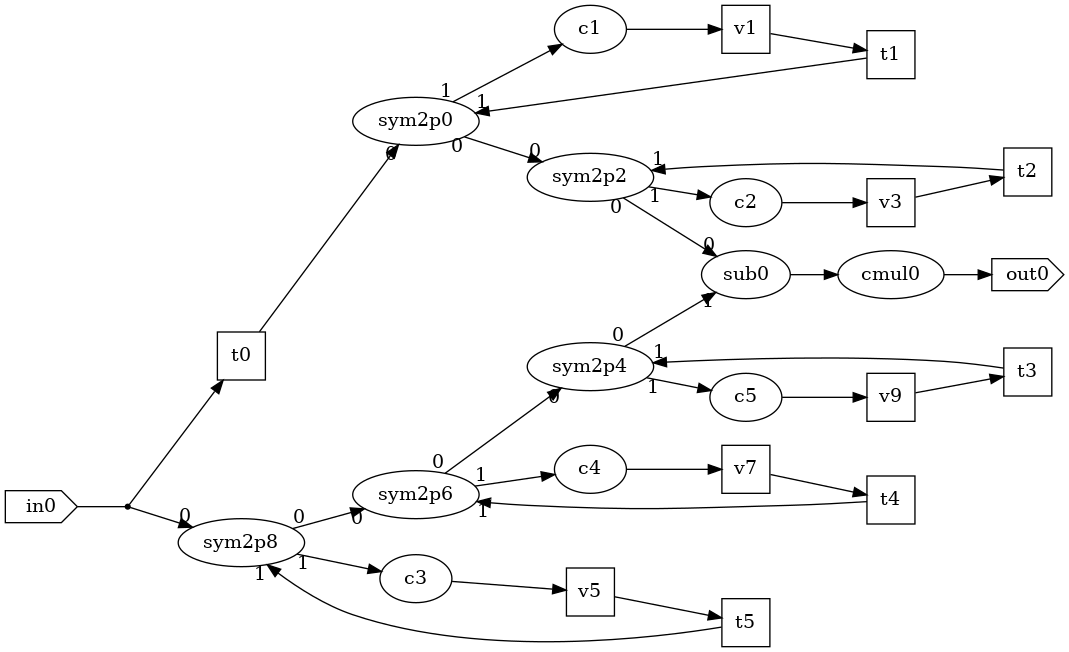

In [84]:
from b_asic.core_operations import Addition, ConstantMultiplication
from b_asic.signal_flow_graph import SFG
from b_asic.special_operations import Delay, Input, Output
from b_asic.sfg_generators import wdf_allpass

a1 = 0.068129
a3 = 0.242429
a5 = 0.461024
a7 = 0.678715
a9 = 0.888980

a10 = 0.4573
a11 = -0.2098
a12 = 0.5695
a13 = -0.2123
a14 = 0.0952
a15 = -0.2258
a16 = -0.4490

# Operations
h_0_in = Input()
h_0_out = Output()
c0 = ConstantMultiplication(0.5)
v0 = Delay()

# Create all WDFes
wdf_a3 = wdf_allpass([a3])
wdf_a7 = wdf_allpass([a7])
wdf_a1 = wdf_allpass([a1])
wdf_a5 = wdf_allpass([a5])
wdf_a9 = wdf_allpass([a9])

# Create the delays used after each WD
v1 = Delay()
v1.graph_id = "v1"
v3 = Delay()
v3.graph_id = "v3"
v5 = Delay()
v5.graph_id = "v5"
v7 = Delay()
v7.graph_id = "v7"
v9 = Delay()
v9.graph_id = "v9"

# Create multiplications used after each WD
c1 = ConstantMultiplication(-1)
c1.graph_id = "c1"
c2 = ConstantMultiplication(-1)
c2.graph_id = "c2"
c3 = ConstantMultiplication(-1)
c3.graph_id = "c3"
c4 = ConstantMultiplication(-1)
c4.graph_id = "c4"
c5 = ConstantMultiplication(-1)
c5.graph_id = "c5"

# Connect the WDFs with input/eachother
v0 <<= h_0_in
wdf_a3 <<= v0
wdf_a7 <<= wdf_a3
wdf_a1 <<= h_0_in
wdf_a5 <<= wdf_a1
wdf_a9 <<= wdf_a5

# The output part
add0 = wdf_a7 - wdf_a9
c0 <<= add0
h_0_out <<= c0

# Connect everything for initial SFG
wdf_a3.connect_external_signals_to_components()
wdf_a7.connect_external_signals_to_components()
wdf_a1.connect_external_signals_to_components()
wdf_a5.connect_external_signals_to_components()
wdf_a9.connect_external_signals_to_components()
H_0 = SFG([h_0_in], [h_0_out])

# Connect the delays/multiplications after each WDF
H_0 = H_0.insert_operation_after("sym2p0.1", c1)
H_0 = H_0.insert_operation_after("c1", v1)
H_0 = H_0.insert_operation_after("sym2p2.1", c2)
H_0 = H_0.insert_operation_after("c2", v3)
H_0 = H_0.insert_operation_after("sym2p8.1", c3)
H_0 = H_0.insert_operation_after("c3", v5)
H_0 = H_0.insert_operation_after("sym2p6.1", c4)
H_0 = H_0.insert_operation_after("c4", v7)
H_0 = H_0.insert_operation_after("sym2p4.1", c5)
H_0 = H_0.insert_operation_after("c5", v9)

H_0

1.2) The H_AP filter.

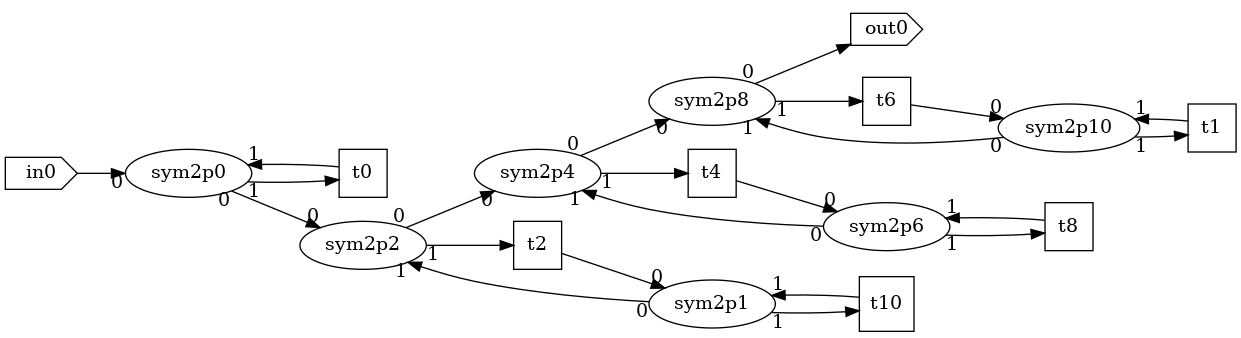

In [85]:
h_ap_in = Input()
h_ap_out = Output()

# Create all WDFs
wdf_a10 = wdf_allpass([a10])
wdf_a11 = wdf_allpass([a11, a12])
wdf_a13 = wdf_allpass([a13, a14])
wdf_a15 = wdf_allpass([a15, a16])

# Connect the WDFs
wdf_a10 <<= h_ap_in
wdf_a11 <<= wdf_a10
wdf_a13 <<= wdf_a11
wdf_a15 <<= wdf_a13
h_ap_out <<= wdf_a15

wdf_a10.connect_external_signals_to_components()
wdf_a11.connect_external_signals_to_components()
wdf_a13.connect_external_signals_to_components()
wdf_a15.connect_external_signals_to_components()

H_AP = SFG([h_ap_in], [h_ap_out])
H_AP

a) Simulate the impulse response for the complete interpolator filter.

In [86]:
from b_asic.simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from b_asic.signal_generator import Impulse
from mplsignal.freq_plots import freqz_fir
from b_asic.utils import upsample

# We start by impulsing through H_AP
h_ap_sim = Simulation(H_AP, [Impulse()])
h_ap_sim.run_for(1000)

# Upsample the results
h_ap_sim_up = upsample(h_ap_sim.results["0"], 2) 

# Put it through H_0
h_0_sim = Simulation(H_0, [h_ap_sim_up])
h_0_sim.run()

# Upsample again
h_0_sim_up = upsample(h_0_sim.results["0"], 2)

# Put it through H_0 again
h_0_sim_2 = Simulation(H_0, [h_0_sim_up])
h_0_sim_2.run()

[-1.4291488476222857e-52]

b) Plot the frequency response both for the signal after the first interpolator stage and for the complete interpolator filter. 

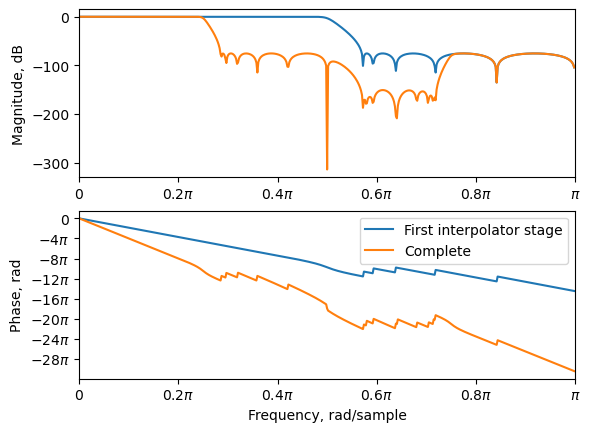

In [87]:
f = freqz_fir(h_0_sim.results["0"])
freqz_fir(h_0_sim_2.results["0"])
plt.legend(["First interpolator stage", "Complete"])

c) What is the passband edge for these two cases? 

first: 0.55pi
complete: 0.3pi

d) Quantize the adaptor coefficients to eleven fractional bits and plot the frequency response. 

In [88]:
Wf = 11

a1_q = round(a1 * 2**Wf) * 2**(-Wf)
a3_q = round(a3 * 2**Wf) * 2**(-Wf)
a5_q = round(a5 * 2**Wf) * 2**(-Wf)
a7_q = round(a7 * 2**Wf) * 2**(-Wf)
a9_q = round(a9 * 2**Wf) * 2**(-Wf)

a10_q = round(a10 * 2**Wf) * 2**(-Wf)
a11_q = round(a11 * 2**Wf) * 2**(-Wf)
a12_q = round(a12 * 2**Wf) * 2**(-Wf)
a13_q = round(a13 * 2**Wf) * 2**(-Wf)
a14_q = round(a14 * 2**Wf) * 2**(-Wf)
a15_q = round(a15 * 2**Wf) * 2**(-Wf)
a16_q = round(a16 * 2**Wf) * 2**(-Wf)

In [89]:
print(a1)
print(a1_q)

0.068129
0.068359375


H_0

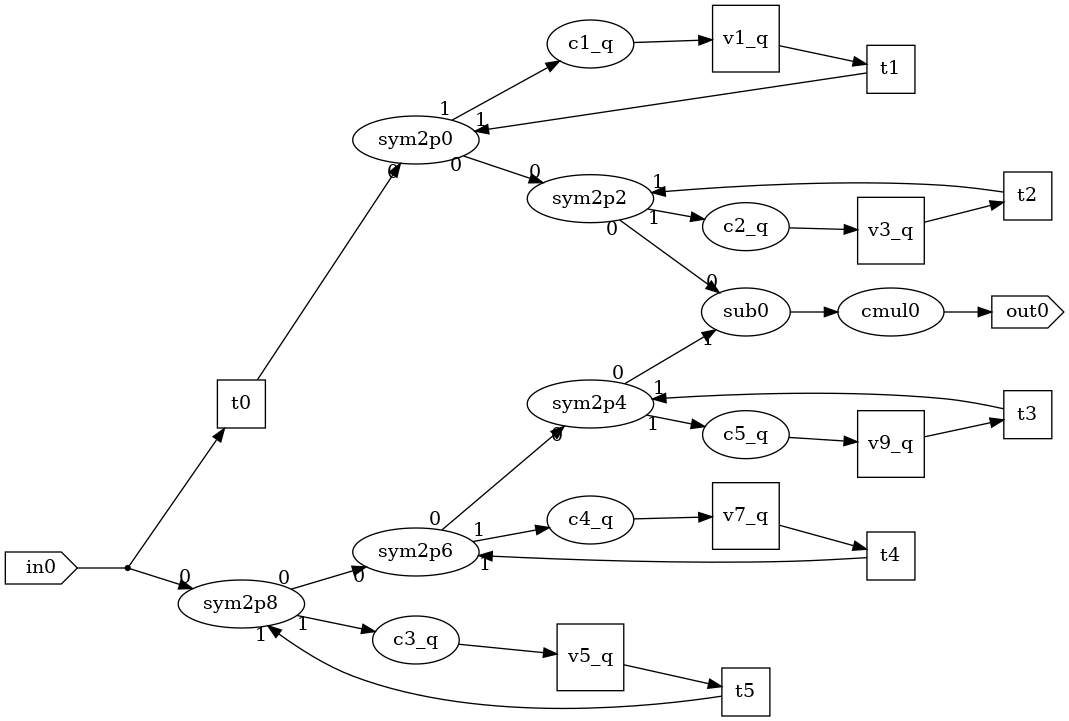

In [90]:
# Operations
h_0_in_q = Input()
h_0_out_q = Output()
c0_q = ConstantMultiplication(0.5)
v0_q = Delay()

# Create all WDFes
wdf_a3_q = wdf_allpass([a3_q])
wdf_a7_q = wdf_allpass([a7_q])
wdf_a1_q = wdf_allpass([a1_q])
wdf_a5_q = wdf_allpass([a5_q])
wdf_a9_q = wdf_allpass([a9_q])

# Create the delays used after each WD
v1_q = Delay()
v1_q.graph_id = "v1_q"
v3_q = Delay()
v3_q.graph_id = "v3_q"
v5_q = Delay()
v5_q.graph_id = "v5_q"
v7_q = Delay()
v7_q.graph_id = "v7_q"
v9_q = Delay()
v9_q.graph_id = "v9_q"

# Create multiplications used after each WD
c1_q = ConstantMultiplication(-1)
c1_q.graph_id = "c1_q"
c2_q = ConstantMultiplication(-1)
c2_q.graph_id = "c2_q"
c3_q = ConstantMultiplication(-1)
c3_q.graph_id = "c3_q"
c4_q = ConstantMultiplication(-1)
c4_q.graph_id = "c4_q"
c5_q = ConstantMultiplication(-1)
c5_q.graph_id = "c5_q"

# Connect the WDFs with input/eachother
v0_q <<= h_0_in_q
wdf_a3_q <<= v0_q
wdf_a7_q <<= wdf_a3_q
wdf_a1_q <<= h_0_in_q
wdf_a5_q <<= wdf_a1_q
wdf_a9_q <<= wdf_a5_q

# The output part
add0_q = wdf_a7_q - wdf_a9_q
c0_q <<= add0_q
h_0_out_q <<= c0_q

# Connect everything for initial SFG
wdf_a3_q.connect_external_signals_to_components()
wdf_a7_q.connect_external_signals_to_components()
wdf_a1_q.connect_external_signals_to_components()
wdf_a5_q.connect_external_signals_to_components()
wdf_a9_q.connect_external_signals_to_components()
H_0_Q = SFG([h_0_in_q], [h_0_out_q])

# Connect the delays/multiplications after each WDF
H_0_Q = H_0_Q.insert_operation_after("sym2p0.1", c1_q)
H_0_Q = H_0_Q.insert_operation_after("c1_q", v1_q)
H_0_Q = H_0_Q.insert_operation_after("sym2p2.1", c2_q)
H_0_Q = H_0_Q.insert_operation_after("c2_q", v3_q)
H_0_Q = H_0_Q.insert_operation_after("sym2p8.1", c3_q)
H_0_Q = H_0_Q.insert_operation_after("c3_q", v5_q)
H_0_Q = H_0_Q.insert_operation_after("sym2p6.1", c4_q)
H_0_Q = H_0_Q.insert_operation_after("c4_q", v7_q)
H_0_Q = H_0_Q.insert_operation_after("sym2p4.1", c5_q)
H_0_Q = H_0_Q.insert_operation_after("c5_q", v9_q)

H_0_Q

H_AP

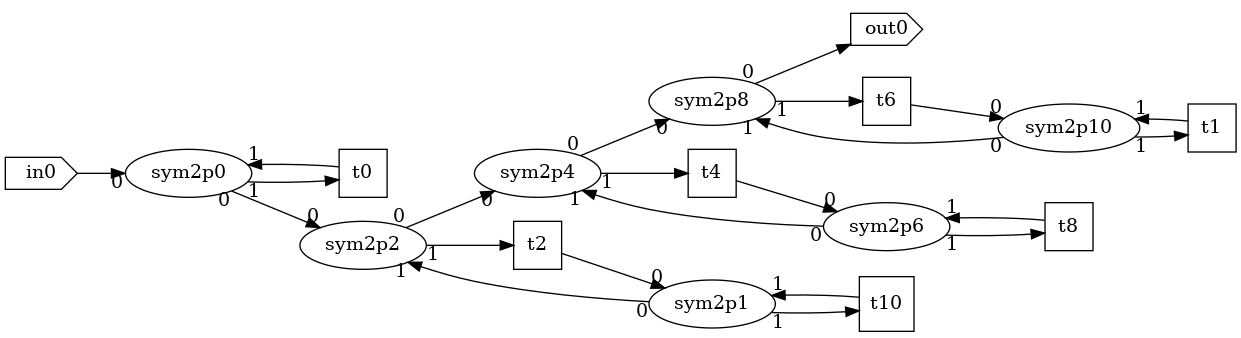

In [91]:
h_ap_in_q = Input()
h_ap_out_q = Output()

# Create all WDFs
wdf_a10_q = wdf_allpass([a10_q])
wdf_a11_q = wdf_allpass([a11_q, a12_q])
wdf_a13_q = wdf_allpass([a13_q, a14_q])
wdf_a15_q = wdf_allpass([a15_q, a16_q])

# Connect the WDFs
wdf_a10_q <<= h_ap_in_q
wdf_a11_q <<= wdf_a10_q
wdf_a13_q <<= wdf_a11_q
wdf_a15_q <<= wdf_a13_q
h_ap_out_q <<= wdf_a15_q

wdf_a10_q.connect_external_signals_to_components()
wdf_a11_q.connect_external_signals_to_components()
wdf_a13_q.connect_external_signals_to_components()
wdf_a15_q.connect_external_signals_to_components()

H_AP_Q = SFG([h_ap_in_q], [h_ap_out_q])
H_AP_Q

e) How does quantization affect the magnitude response? 

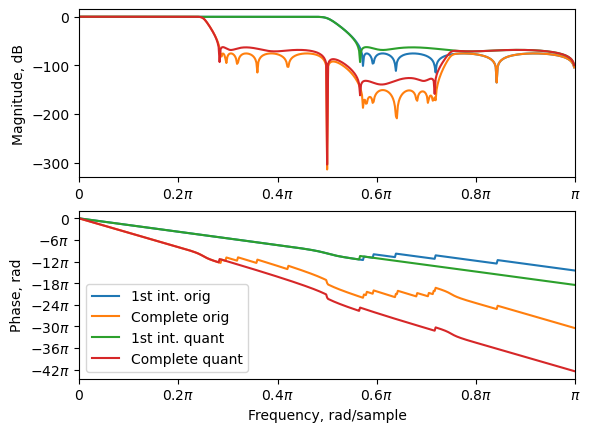

In [92]:
# We start by impulsing through H_AP
h_ap_sim_q = Simulation(H_AP_Q, [Impulse()])
h_ap_sim_q.run_for(1000)

# Upsample the results
h_ap_sim_up_q = upsample(h_ap_sim_q.results["0"], 2) 

# Put it through H_0
h_0_sim_q = Simulation(H_0_Q, [h_ap_sim_up_q])
h_0_sim_q.run()

# Upsample again
h_0_sim_up_q = upsample(h_0_sim_q.results["0"], 2)

# Put it through H_0 again
h_0_sim_2_q = Simulation(H_0_Q, [h_0_sim_up_q])
h_0_sim_2_q.run()

f = freqz_fir(h_0_sim.results["0"])
f = freqz_fir(h_0_sim_2.results["0"])
f = freqz_fir(h_0_sim_q.results["0"])
freqz_fir(h_0_sim_2_q.results["0"])
plt.legend(["1st int. orig", "Complete orig", "1st int. quant", "Complete quant"])

It makes it a bit worse.

f) Simulate the complete interpolator filter using a random signal and save both the input and output data. These signals will be used for reference at later design iterations. 

In [93]:
#import pickle
#
#data = np.random.rand(100)*2 - 1
#with open("data.txt", "wb") as f:
#    pickle.dump(data, f)

In [94]:
import pickle
with open("data.txt", "rb") as f:
    data = pickle.load(f)

# We start by impulsing through H_AP
h_ap_sim_q = Simulation(H_AP_Q, [data])
h_ap_sim_q.run_for(100)

# Upsample the results
h_ap_sim_up_q = upsample(h_ap_sim_q.results["0"], 2) 

# Put it through H_0
h_0_sim_q = Simulation(H_0_Q, [h_ap_sim_up_q])
h_0_sim_q.run()

# Upsample again
h_0_sim_up_q = upsample(h_0_sim_q.results["0"], 2)

# Put it through H_0 again
h_0_sim_2_q = Simulation(H_0_Q, [h_0_sim_up_q])
h_0_sim_2_q.run()

[0.08738236676816927]

g) Plot the discrete delay element values for one of the delays in the last stage bireciprocal filter and for the discrete inputs to the adder in the last stage bireciprocal filter. Comments? 

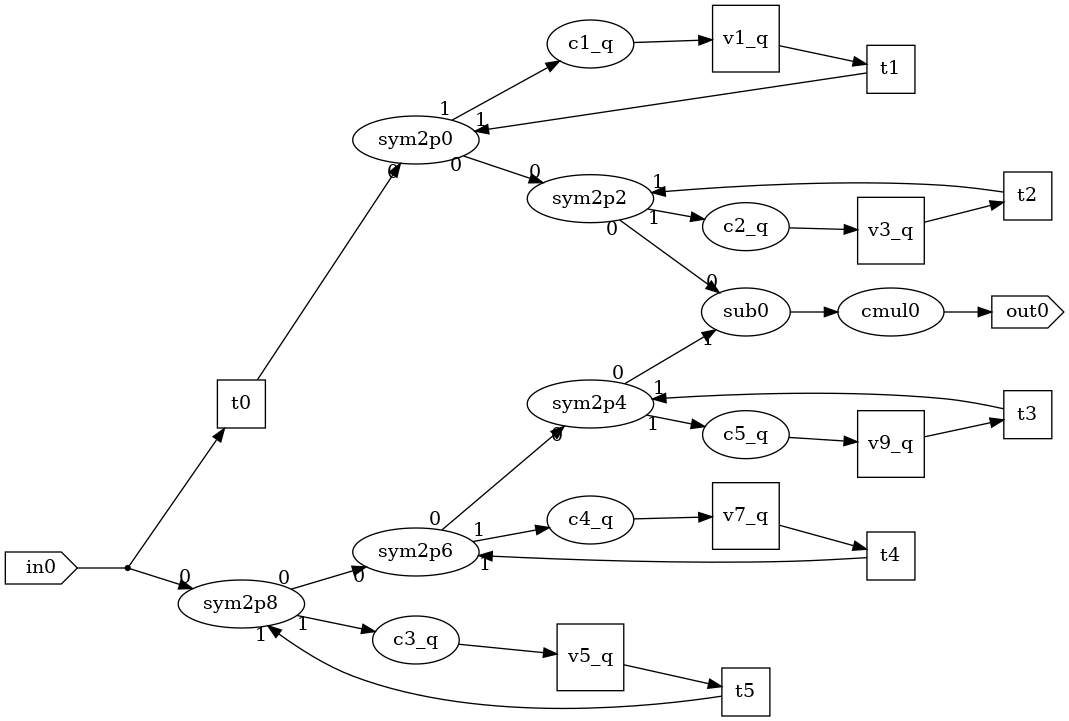

In [95]:
H_0_Q

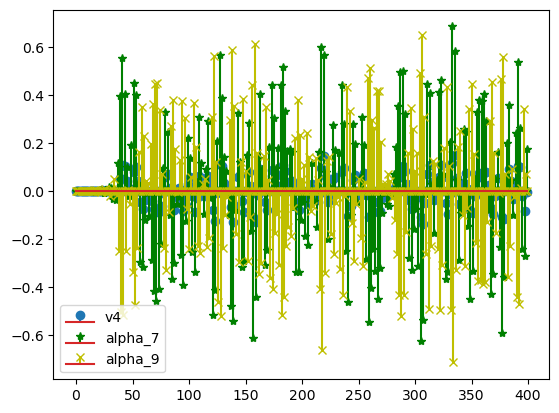

In [96]:
fig, ax = plt.subplots()
ax.stem(h_0_sim_2_q.results["t2"])
ax.stem(h_0_sim_2_q.results["sym2p2.0"], "g", markerfmt="*")
ax.stem(h_0_sim_2_q.results["sym2p4.0"], "y", markerfmt="x")
ax.legend(["v4", "alpha_7", "alpha_9"])

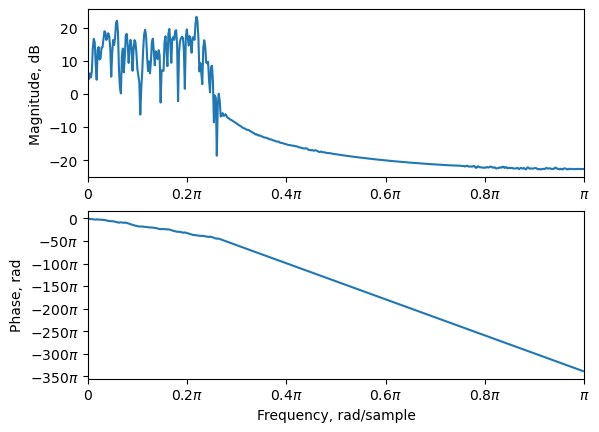

In [97]:
f = freqz_fir(h_0_sim_2_q.results["0"])

In [98]:
#h_0_sim_2_q.show()

Not sure what conclusions to make? The delayed value is larger than the output from the WDF? That might be reasonable if you take a look on the inside of a WDF as shown in lab1.

h) Determine the number of adaptor operations required per second. 

In [99]:
fs = 1.6e6
print((7*fs + 5*2*fs + 5*4*fs)/1e6, "M op/s")

59.2 M op/s
